---
title: "Creating DataBlock from Numpy Array"
execute: 
  enabled: false
  freeze: true
date: "6/20/2024"
categories: [fastai, numpy, datablock]
---


> Need to prepare our data into list of dictionaries for each sample, eg ```L([{x: feature1, y: label1},  {x: feature2, y: label2},  {x: featuren, y: labeln} ])``` format and feed the function into get_image param of DataBlock.

In [1]:

import numpy as np
import pandas as pd
import torch
from fastai.data.core import Datasets
from fastai.vision.all import *

### Load data

In [2]:
# ref: https://www.kaggle.com/code/drkaggle22/digit-recognizer-solution-99-accuracy?scriptVersionId=181451739&cellId=3
import struct

def read_idx(filename):
    with open(filename, 'rb') as f:
        zero, data_type, dims= struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        
        return np.frombuffer(f.read(), dtype=np.uint8).reshape(shape)

def load_mnist(image_path, label_path):
    images = read_idx(image_path)
    labels = read_idx(label_path)
    return images, labels


In [3]:

train_image_path = '/kaggle/input/mnist-dataset/train-images-idx3-ubyte/train-images-idx3-ubyte'
train_label_path = '/kaggle/input/mnist-dataset/train-labels-idx1-ubyte/train-labels-idx1-ubyte'
test_image_path =  '/kaggle/input/mnist-dataset/t10k-images-idx3-ubyte/t10k-images-idx3-ubyte'
test_label_path =  '/kaggle/input/mnist-dataset/t10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte'

In [4]:
train_images, train_labels = load_mnist(train_image_path, train_label_path)
test_images, test_labels = load_mnist(test_image_path, test_label_path)
print(f'Train images shape: {train_images.shape}')
print(f'Train labels shape: {train_labels.shape}')
print(f'Test images shape: {test_images.shape}')
print(f'Test labels shape: {test_labels.shape}')

Train images shape: (60000, 28, 28)
Train labels shape: (60000,)
Test images shape: (10000, 28, 28)
Test labels shape: (10000,)


In [5]:
from collections import Counter
print(Counter(train_labels))
n_classes = len(Counter(train_labels))
print('n_classes:', n_classes)

Counter({1: 6742, 7: 6265, 3: 6131, 2: 5958, 9: 5949, 0: 5923, 6: 5918, 8: 5851, 4: 5842, 5: 5421})
n_classes: 10


In [6]:

def tensor_to_labelled_pil_image(tensor: np.ndarray, labels=None) -> list:
    ''' ref: https://www.kaggle.com/code/pemtaira/digit-recognizer-fastai-v2-2020
    shape image shape (total sample, height, width) into (total sample, 3, height, width),
    save into dictionary (x: reshaped img, y: label). Append dictionary to list. return list.
    '''
    reshaped = tensor.reshape(-1, 28, 28) #  (total sample, 28, 28) --> (total sample, 28, 28)
    reshaped = np.stack((reshaped,) *3, axis = 1) # (total sample, 28, 28) --> (total sample, 3, 28, 28)
    image_arr = []
    
    # loop each reshaped images, convert to float tensor, convert to PILImage, save as dictionary, append to list
    for idx, current_image in enumerate(reshaped):
        img = torch.tensor(current_image, dtype=torch.float) / 255.
        img = PILImage(to_image(img))
        
        final_data = None

        if (labels is None):
            final_data = {'x': img, 'y': None}
        else:
            final_data = {'x': img, 'y': labels[idx]}

        image_arr.append(final_data)

    return image_arr


def get_image(l:list) -> L:
    """
    returns list of [{'x': feature tensor, 'y': class label},
                    {...}, {...} ]
    L is fastai's implementation of list
    """
    features = l[0]
    labels = l[1]
    all_imgs = tensor_to_labelled_pil_image(features, labels)
    return L(all_imgs)
    

In [7]:
def get_y_fromdict(item):
    """get y from each sample dictionary returned from get_image()"""
    return item['y']

def get_x_fromdict(item):
    """get x from each sample dictionary returned from get_image()"""
    return item['x']

### Initialize DataBlock

`blocks=(ImageBlock(cls=PILImage), CategoryBlock)`
> Here we specify that our input data is an image and of class PILImage, our label is categorical


`get_items=get_image`
> Function where we return list of {x:features, y:label} dictionary for all our samples


`splitter=RandomSplitter(valid_pct=0.2, seed=42)`
> Describe how we want to split our data; Here we want to split train and test data into 80-20 split randomly. We specify seed to have reproducible result for each run.


`get_x=get_x_fromdict`
> Function to extract features from list returned from get_image() function. Note, we could also use lambda function here `get_x = (lambda item: item['x'])`.


`get_y=get_y_fromdict`
> Function to extract label from list returned from get_image() function. Note, we could also use lambda function here `get_y = (lambda item: item['y'])`.

Note that if we use lambda function when initializing DataBlock, we might need to use `dill` library to export our model.

In [8]:
mnist_db = DataBlock(
    blocks=(ImageBlock(cls=PILImage), CategoryBlock), 
    get_items=get_image, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=get_y_fromdict,#(lambda item: item['y']),
    get_x=get_x_fromdict #(lambda item: item['x'])
)

In [9]:
# checking featues and labels shapes
print(train_images.shape)
print(train_labels.shape)

(60000, 28, 28)
(60000,)


In [10]:
# stacking both train and test sets' features

print(train_images.shape)
print(test_images.shape)
np.vstack([train_images, test_images]).shape

(60000, 28, 28)
(10000, 28, 28)


(70000, 28, 28)

In [11]:
# stacking both train and test sets
print(train_labels.shape)
print(test_labels.shape)
np.hstack([train_labels, test_labels]).shape

(60000,)
(10000,)


(70000,)

This is how our data is reshaped in tensor_to_labelled_pil_image() function.

In [12]:
features = np.vstack([train_images, test_images])
features_reshaped = features.reshape(-1, 28, 28)
features_reshaped_stacked = np.stack((features_reshaped,) *3, axis = 1)

print('features.shape', features.shape)
print('features_reshaped.shape', features_reshaped.shape)
print('features_reshaped_stacked.shape', features_reshaped_stacked.shape)

features.shape (70000, 28, 28)
features_reshaped.shape (70000, 28, 28)
features_reshaped_stacked.shape (70000, 3, 28, 28)


### Quick plot

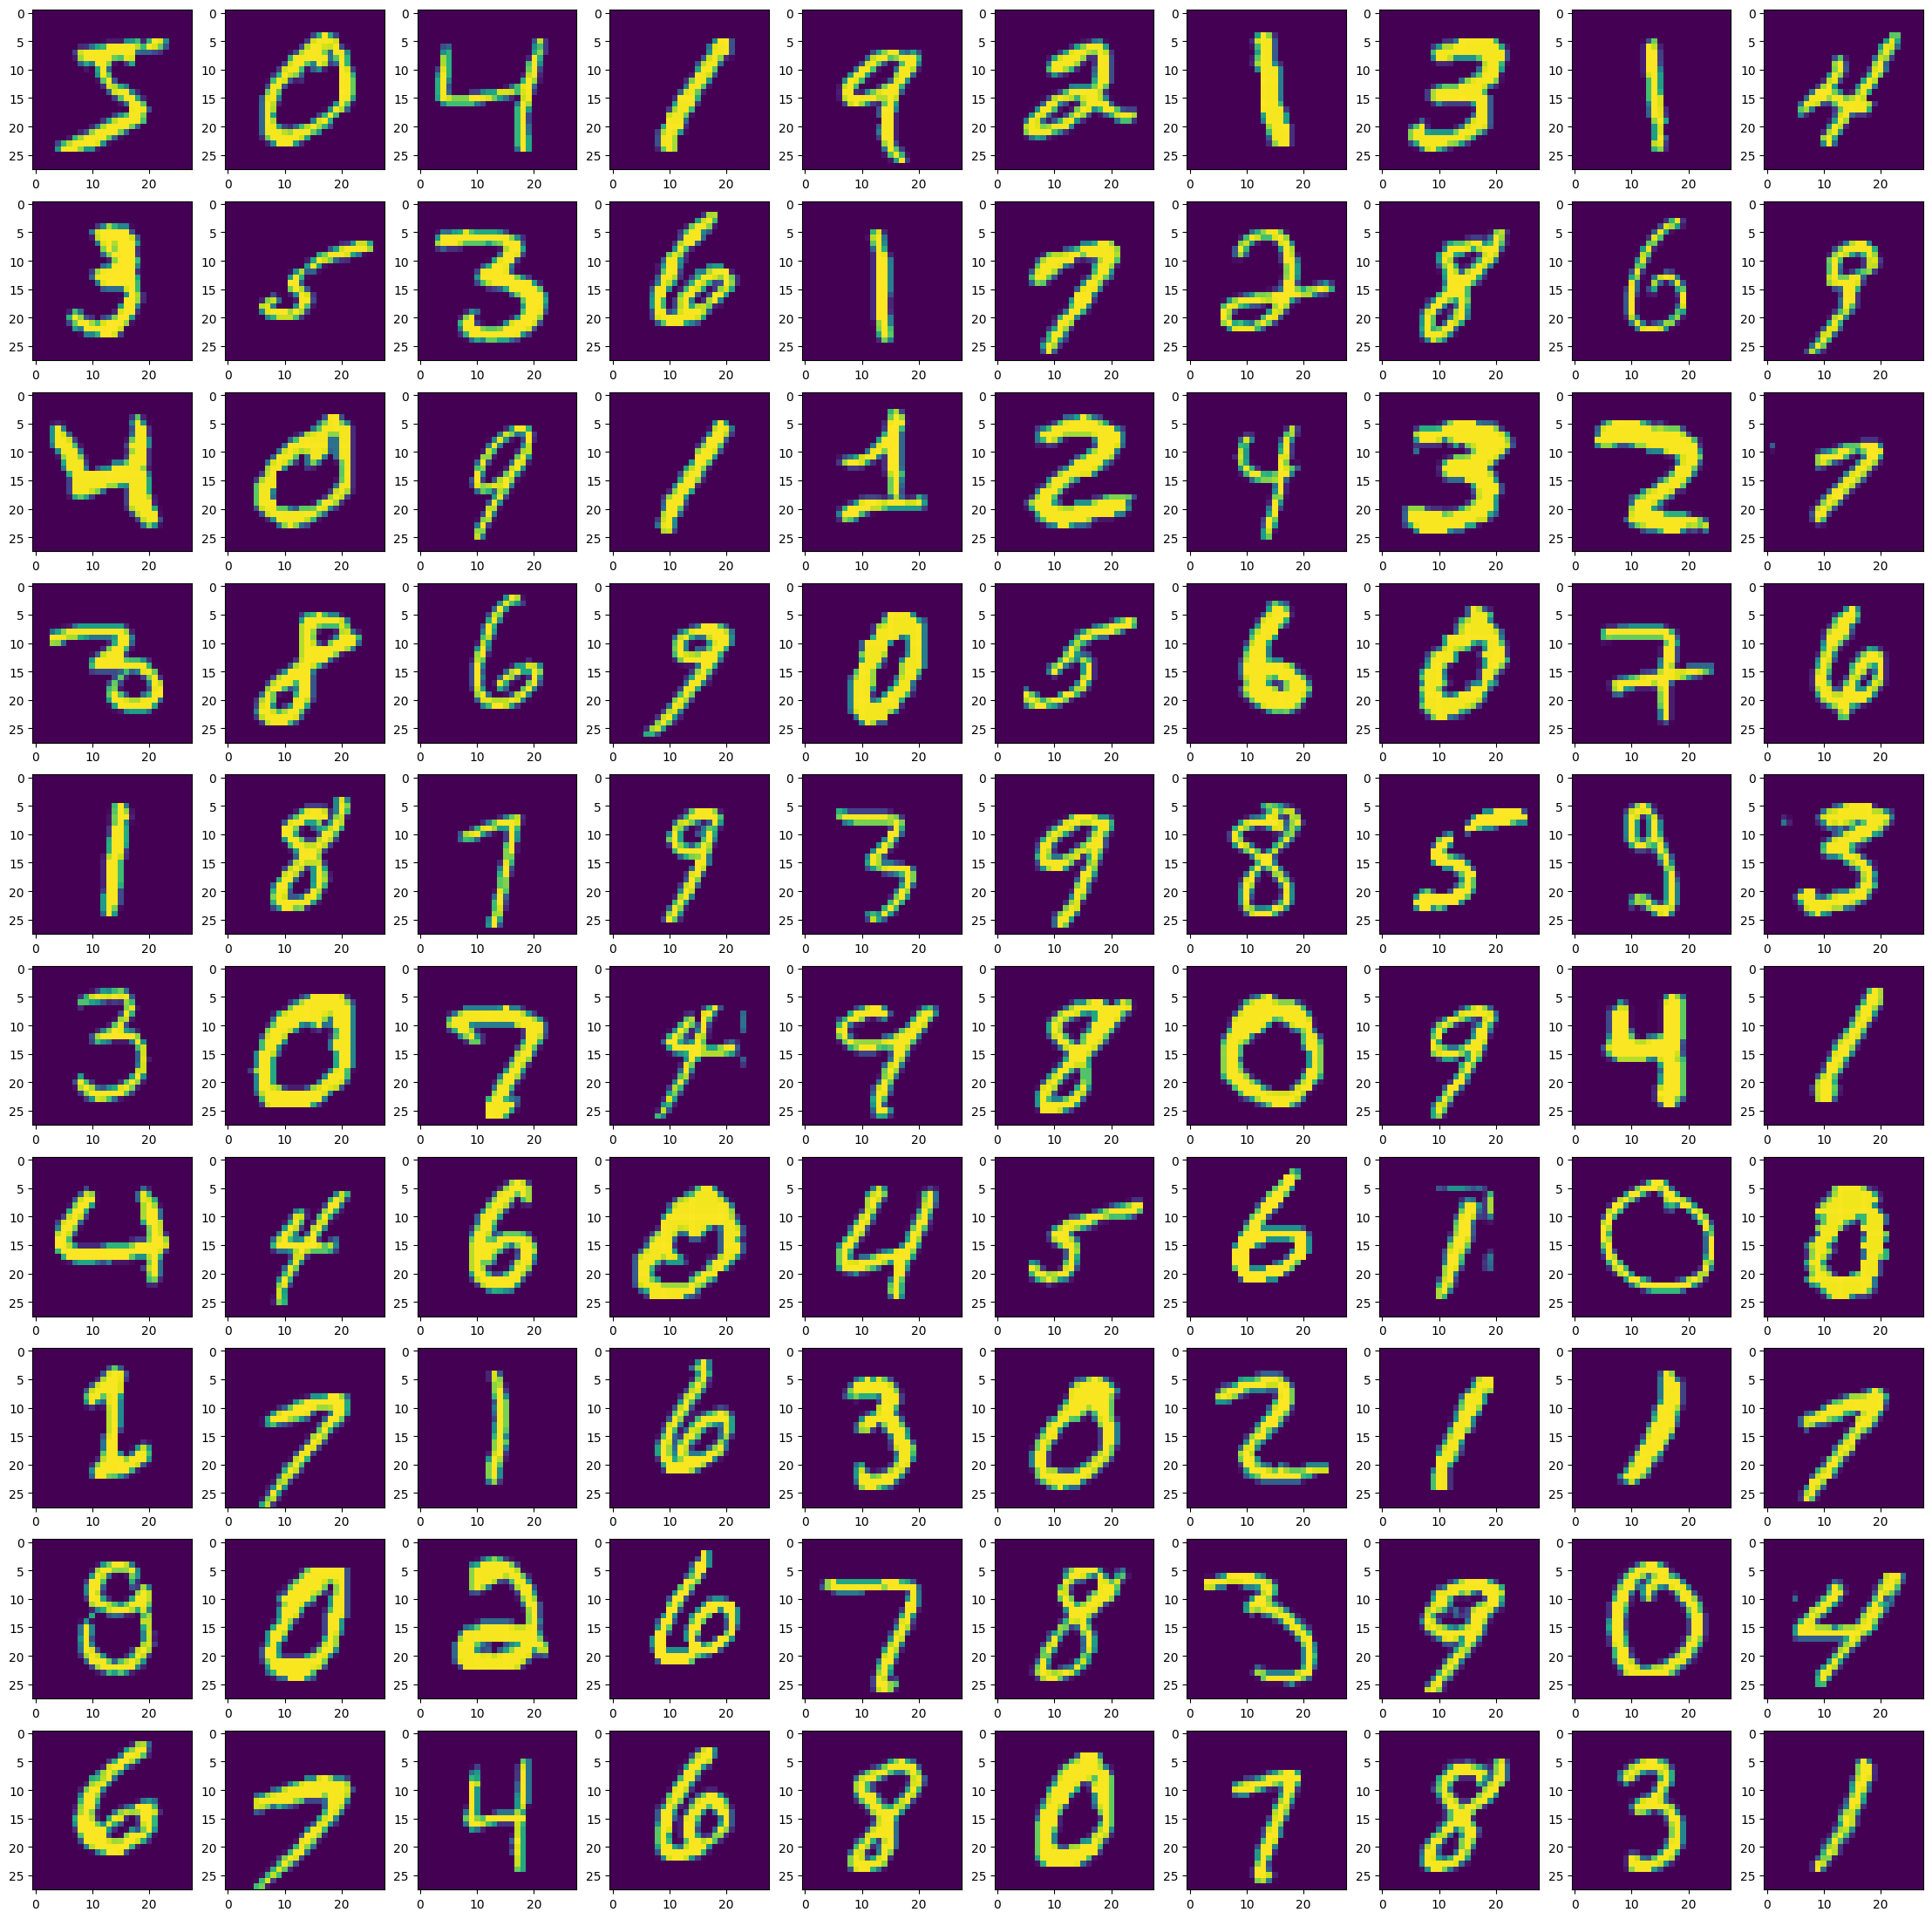

In [ ]:
# ref: https://stackoverflow.com/a/59296746
import matplotlib.pyplot as plt
fig, axes = plt.subplots(10,10, figsize=(28,28))
for i,ax in enumerate(axes.flat):
    ax.imshow(features_reshaped[i])

Load our source data

In [ ]:
dls = mnist_db.dataloaders([np.vstack([train_images, test_images]),
                            np.hstack([train_labels, test_labels])])

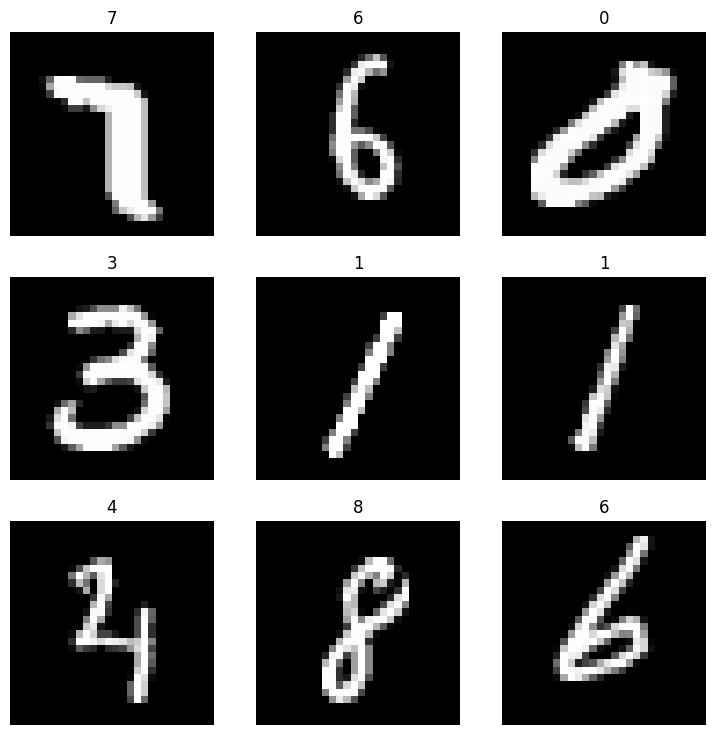

In [ ]:
dls.show_batch()

### Train model

In [ ]:
learn = vision_learner(dls, resnet18, metrics=[error_rate, accuracy])
learn.fine_tune(10)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 146MB/s]


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.714643,0.483854,0.155143,0.844857,04:06


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.170800,0.091101,0.026429,0.973571,08:18
1,0.098211,0.057546,0.018071,0.981929,07:50
2,0.070756,0.043570,0.013071,0.986929,07:54
3,0.045105,0.036998,0.010214,0.989786,07:51
4,0.034318,0.037484,0.010214,0.989786,07:51
5,0.032253,0.031844,0.007857,0.992143,07:49
6,0.013959,0.029695,0.006714,0.993286,07:47
7,0.006643,0.028861,0.006643,0.993357,07:48
8,0.002887,0.027575,0.006143,0.993857,07:48


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



### Save model

In [ ]:
learn.export('model2.pkl')

If we use lambda function when initializing DataBlock, we can use dill to save model. Eg:

In [ ]:

import dill
learn.export('model2.pkl', pickle_module=dill)
